In [1]:
%matplotlib inline
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid
import cv2

# Setup Model
model = get_model('hg_furukawa_original', 51)

room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]
n_classes = 44
split = [21, 12, 11]

model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('model_best_val_loss_var.pkl', map_location='cpu')
model.load_state_dict(checkpoint['model_state'])
model.eval()
print("Model loaded.")


Model loaded.


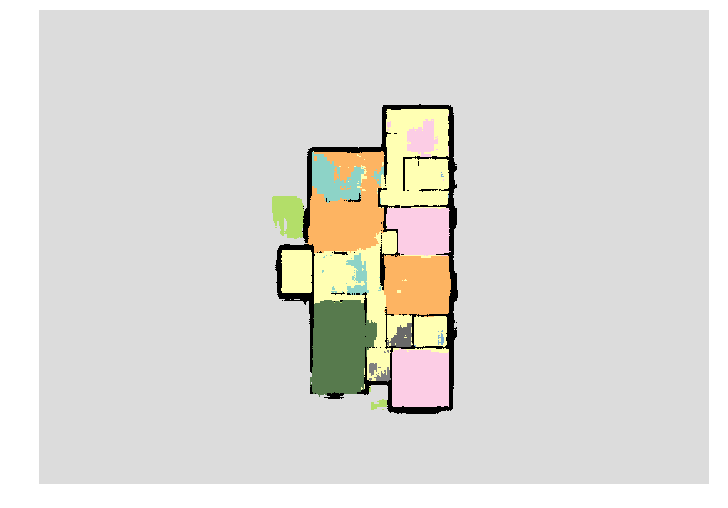

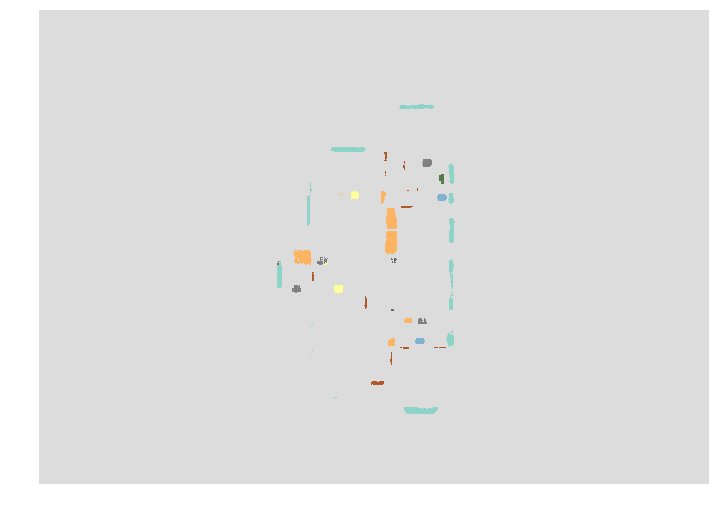

In [2]:
fplan_orig = cv2.imread('data/floorplan/Working/fp1/fp1.png')
output_path = 'data/floorplan/Working/fp1/comparison_image.png'

fplan = cv2.cvtColor(fplan_orig, cv2.COLOR_BGR2RGB)  # correct color channels
fplan = np.moveaxis(fplan, -1, 0) # correct the dimension oreder
fplan = 2 * (fplan / 255.0) - 1  # Normalization values to range -1 and 1
image = torch.FloatTensor(fplan)  # Convert NumPy array to Pytorch tensor
image = image.unsqueeze(0) # add extra dim 

prediction = model(image) # pass the tensor to the model

with torch.no_grad():
    height, width = image.shape[2], image.shape[3]
    img_size = (height, width)

    # Extracting room and icon predictions
    rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
    rooms_pred = np.argmax(rooms_pred, axis=0)

    icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
    icons_pred = np.argmax(icons_pred, axis=0)

    # Plotting the predictions
    plt.figure(figsize=(12,12))
    ax = plt.subplot(1, 1, 1)
    ax.axis('off')
    rseg = ax.imshow(rooms_pred, cmap='rooms')
    plt.show()

    plt.figure(figsize=(12,12))
    ax = plt.subplot(1, 1, 1)
    ax.axis('off')
    iseg = ax.imshow(icons_pred, cmap='icons')
    plt.show()

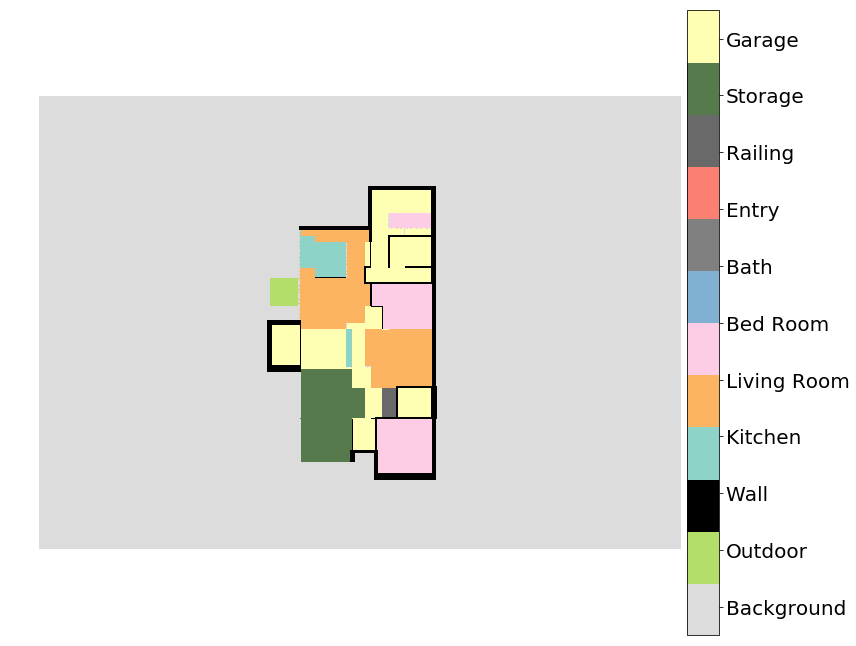

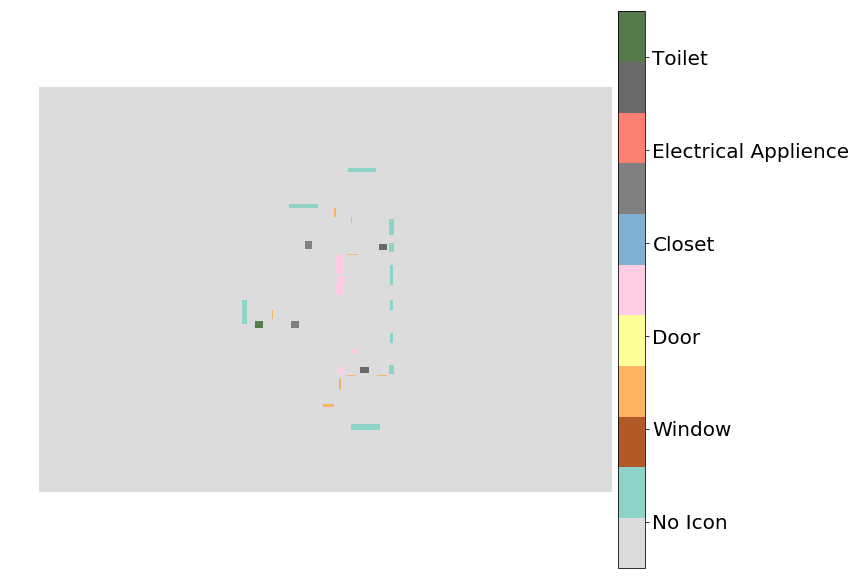

In [3]:
heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)
plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(pol_room_seg, cmap='rooms')
cbar = plt.colorbar(rseg, ticks=np.arange(len(room_classes)) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(pol_icon_seg, cmap='icons')
cbar = plt.colorbar(iseg, ticks=np.arange(len(icon_classes)) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.tight_layout()
plt.show()


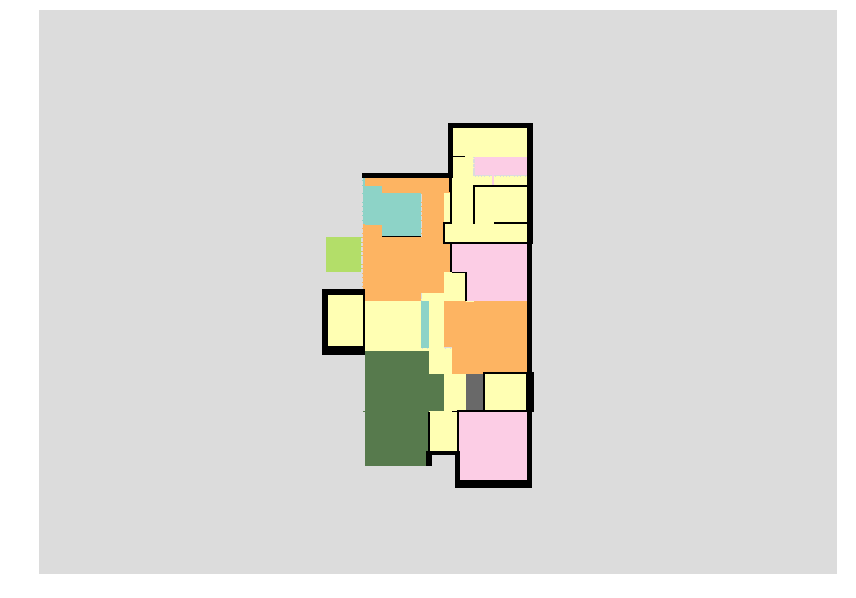

In [4]:
# Remove the color bar
heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)
plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(pol_room_seg, cmap='rooms')
#cbar = plt.colorbar(rseg, ticks=np.arange(len(room_classes)) + 0.5, fraction=0.046, pad=0.01)
#cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.tight_layout()
plt.show()

Comparison image saved at: data/floorplan/Working/fp1/comparison_image.png


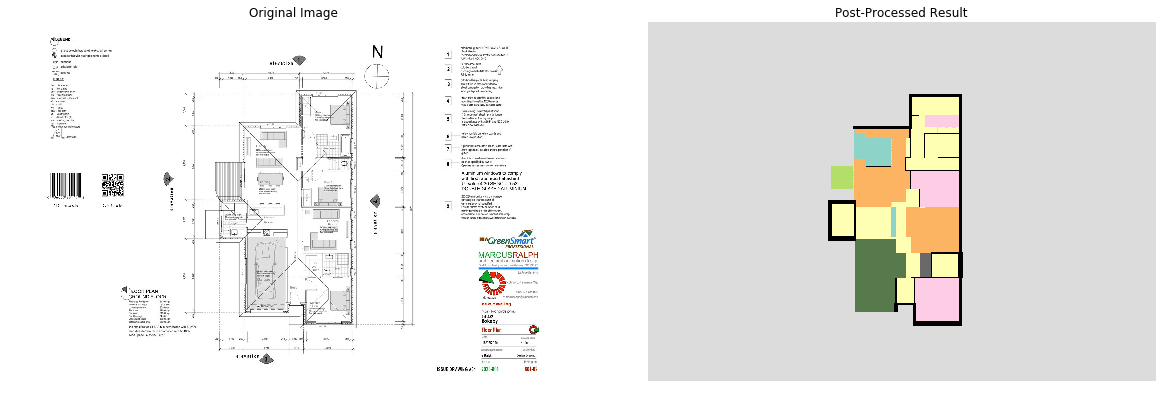

In [5]:
# Plotting input image and post-processed result image side by side
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(fplan_orig)
plt.title('Original Image')
plt.axis('off')

#n_rooms = len(room_classes)

plt.subplot(1,2,2)
plt.imshow(pol_room_seg, cmap='rooms')
plt.title('Post-Processed Result')
plt.axis('off')

# Saving the comparison image
plt.savefig(output_path)
print(f'Comparison image saved at: {output_path}')


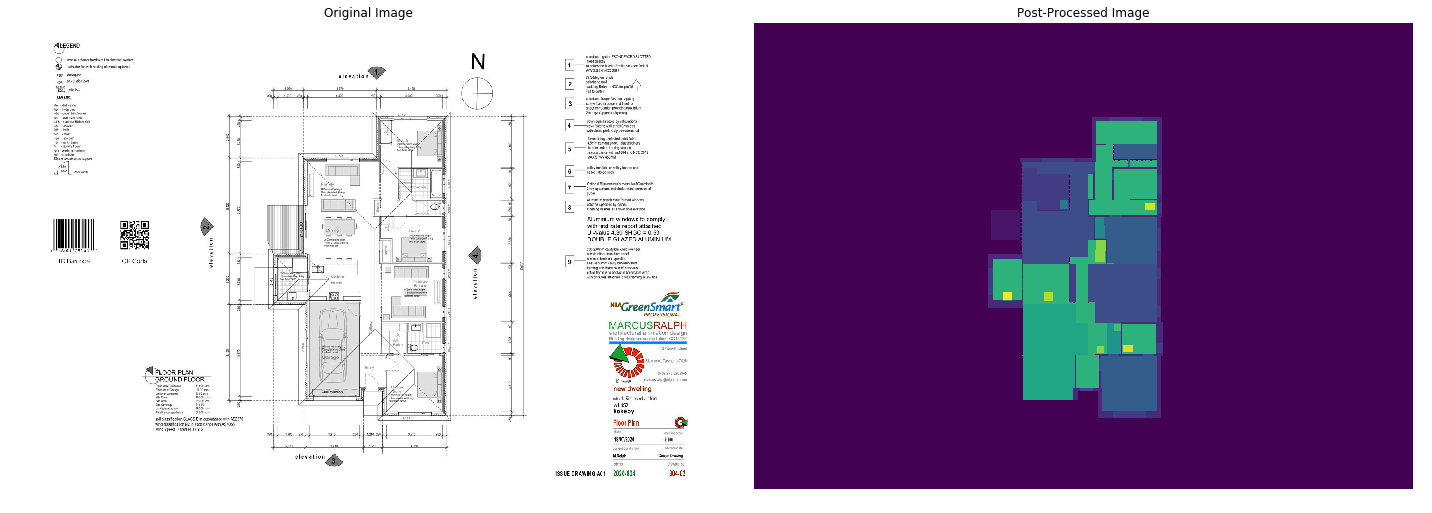

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Display original image
axs[0].imshow(fplan_orig)  
axs[0].axis('off')
axs[0].set_title('Original Image')

# Display post-processed image
# Combine room and icon segmentation for visualization
combined_segmentation = pol_room_seg + pol_icon_seg
#combined_segmentation = pol_room_seg # I think pol_room_seg only shows best result
axs[1].imshow(combined_segmentation)
axs[1].axis('off')
axs[1].set_title('Post-Processed Image')

plt.tight_layout()
plt.show()
